# Trabajo Práctico 1: Propiedades en Venta - Árbol de decisión

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

In [1]:
!pip install 'dtreeviz'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.tree import export_text
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

## Carga de datos y preprocesamiento

### Carga de datos

Fijo una semilla.

In [3]:
semilla = 137

Cargo los datos de los avisos con tipo de precio.

In [4]:
df = pd.read_csv("https://drive.usercontent.google.com/u/1/uc?id=1Aib-aBN7wcI3EuPTX-Kd7VyZVwffB_sQ&export=download",
                 index_col=0)

### Encoding

Hago OneHot encoding para el tipo de propiedad.

In [5]:
# OneHot encoding para tipo de propiedad
df = pd.get_dummies(df, columns=["property_type"], drop_first=True)

Encodeo con LabelEncoder los barrios, y no opto por OneHot para esta variable por la cantidad de columnas que se generarian al encodear de esa forma los barrios

In [6]:
#le = LabelEncoder()

#le.fit(df['neighbourhood'])
#labels = le.transform(df['neighbourhood'])
#df['neighbourhood'] = labels
# OneHot encoding para barrio
df = pd.get_dummies(df, columns=["neighbourhood"], drop_first=True)

### Selección de features

No uso `property_price` porque contiene información sobre el precio, así como tampoco utilizo `property_surface_total` ya que se utilizo para generar `precio_m2`, la cual a su vez se utilizo para generar el target, y otras variables irrelevantes para el analisis, `id` y `property_title`, por ser estas variables particulares de cada aviso y sin relación con el target.

In [7]:
onehot = [col for col in df.columns if col.startswith(("neighbourhood_"))]

features = ['property_rooms',
            'property_bedrooms',
            'property_surface_total',
            'property_surface_covered',
            'latitud',
            'longitud',
            'property_type_Departamento',
            'property_type_PH',
            ]

features = features + onehot

target = ['tipo_precio']

Genero dos dataframes, uno para nuestro x (features), y otro para nuestro y (target a predecir).

In [8]:
df_x = df[features]
df_y = df[target]

## Entrenamiento de modelos

### Generación de conjuntos de train y test

Genero los conjuntos de train (80%) y test (20%).

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, stratify=df[target].values, random_state=semilla)

### Entrenamiento de un árbol con parámetros por defecto

Entreno un árbol con los hiperparámetros por defecto.

In [10]:
arbol_defecto = DecisionTreeClassifier()

arbol_defecto.fit(X_train, y_train)

DecisionTreeClassifier()

Vemos los hiperparámetros del árbol.

In [11]:
print(arbol_defecto.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


Predigo los valores del conjunto de test

In [12]:
y_pred_base = arbol_defecto.predict(X_test)

Muestro la matriz de confusion

Text(50.722222222222214, 0.5, 'True')

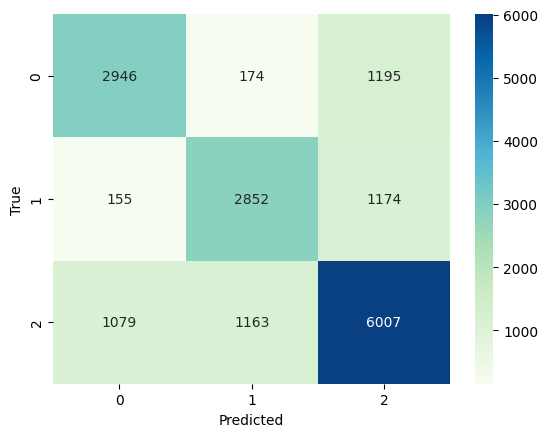

In [13]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_pred_base, y_test)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Ahora vemos los scores.

In [14]:
accuracy=accuracy_score(y_test, y_pred_base)
recall=recall_score(y_test, y_pred_base, average='weighted')
f1=f1_score(y_test, y_pred_base, average='weighted')
precision=precision_score(y_test, y_pred_base, average='weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7049865631531801
Recall: 0.7049865631531801
Precision: 0.7053311731472452
f1 score: 0.7050938808556924


In [15]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

        alto       0.68      0.70      0.69      4180
        bajo       0.68      0.68      0.68      4189
       medio       0.73      0.72      0.72      8376

    accuracy                           0.70     16745
   macro avg       0.70      0.70      0.70     16745
weighted avg       0.71      0.70      0.71     16745



Visualizamos las reglas

In [16]:
reglas = export_text(arbol_defecto, feature_names=list(features))
print(reglas)

|--- latitud <= -34.60
|   |--- neighbourhood_Puerto Madero <= 0.50
|   |   |--- neighbourhood_Caballito <= 0.50
|   |   |   |--- longitud <= -34.59
|   |   |   |   |--- longitud <= -58.41
|   |   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |   |--- latitud <= -34.66
|   |   |   |   |   |   |   |--- property_type_Departamento <= 0.50
|   |   |   |   |   |   |   |   |--- property_surface_total <= 120.31
|   |   |   |   |   |   |   |   |   |--- property_surface_total <= 63.50
|   |   |   |   |   |   |   |   |   |   |--- property_surface_covered <= 58.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- property_surface_covered >  58.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: bajo
|   |   |   |   |   |   |   |   |   |--- property_surface_total >  63.50
|   |   |   |   |   |   |   |   |   |   |--- property_surface_covered <= 61.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated bra

Vemos la lista de importancias de los features

In [17]:
sorted(list(zip(df_x.columns.to_list(), arbol_defecto.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.29816718504207645),
 ('longitud', 0.2410271977790571),
 ('property_surface_total', 0.16830453017140443),
 ('property_surface_covered', 0.15628565821773213),
 ('property_rooms', 0.027258288518065464),
 ('neighbourhood_Puerto Madero', 0.025860727852942546),
 ('property_bedrooms', 0.01665682988398048),
 ('neighbourhood_Caballito', 0.0103380797696533),
 ('property_type_Departamento', 0.00979509933869836),
 ('property_type_PH', 0.006883981451295671),
 ('neighbourhood_Palermo', 0.0027787106525601767),
 ('neighbourhood_Villa Crespo', 0.0021060601046193187),
 ('neighbourhood_Barrio Norte', 0.0020603142939924052),
 ('neighbourhood_Belgrano', 0.001999419888919519),
 ('neighbourhood_Boca', 0.0019321792916512281),
 ('neighbourhood_Recoleta', 0.0018432665300744772),
 ('neighbourhood_Balvanera', 0.0018043889036648767),
 ('neighbourhood_Villa Devoto', 0.001493883355421005),
 ('neighbourhood_Villa Urquiza', 0.0014623148249987546),
 ('neighbourhood_Almagro', 0.0014543190948948005),
 ('ne

### Entrenamiento con RandomSearch

*min_samples_split*: número mínimo de muestras que se requieren en un nodo antes de que se pueda dividir en nodos hijos adicionales

*min_samples_leaf*: número mínimo de muestras que se requieren en un nodo hoja

*max_depth*: establece un límite en la profundidad del árbol

*ccp_alpha*: parámetro de poda

*criterion*: criterio mediante el cual se establecen los nodos (ganancia de información vs impureza de gini)

Busco los mejores hiperparametros con cross validation con 5 folds y 30 iteraciones mediante random search. Opto por optimizar la métrica de f1 score.

In [18]:
#Cantidad de combinaciones
n = 30
folds = 5

#Cantidad de splits para el Cross Validation
params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,30)),
                'min_samples_split': list(range(2,30)),
                'ccp_alpha':np.linspace(0.001, 0.002),
                'max_depth':list(range(1,16))}

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

# Clasificador
arbol_base = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=arbol_base,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=30,
                   param_distributions={'ccp_alpha': array([0.001     , 0.00102041, 0.00104082, 0.00106122, 0.00108163,
       0.00110204, 0.00112245, 0.00114286, 0.00116327, 0.00118367,
       0.00120408, 0.00122449, 0.0012449 , 0.00126531, 0.00128571,
       0.00130612, 0.00132653, 0....
       0.00191837, 0.00193878, 0.00195918, 0.00197959, 0.002     ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29]},
                   random_state=137,
                   scoring=make_scorer(f1_score, average=micro))

Los hiperparámetros que optimizan el f1 score son:

In [19]:
print("Mejores hiperparámetros: ", str(randomcv.best_params_))
print("Mejor puntaje: ", str(randomcv.best_score_))

Mejores hiperparámetros:  {'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 15, 'criterion': 'entropy', 'ccp_alpha': 0.0013061224489795918}
Mejor puntaje:  0.5951595518977937


Entreno el árbol con los mejores hiperparametros encontrados.

In [20]:
# Creo y entreno los mejores arboles de cada search
arbol_optimizado_rs = DecisionTreeClassifier().set_params(**randomcv.best_params_)

arbol_optimizado_rs.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0013061224489795918, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=7)

Vemos los scores de cross validation.

In [21]:
# Genero los scores de cross validation
scoresrs = cross_val_score(arbol_optimizado_rs, X_train, y_train, cv=kfoldcv)

print("Scores de random search por cada fold: ", scoresrs)

Scores de random search por cada fold:  [0.59861153 0.59040012 0.59589399 0.59178798 0.59910414]


Reglas del arbol generado con random search.

In [22]:
reglasrs = export_text(arbol_optimizado_rs, feature_names=list(features))
print(reglasrs)

|--- latitud <= -34.60
|   |--- neighbourhood_Puerto Madero <= 0.50
|   |   |--- longitud <= -34.59
|   |   |   |--- neighbourhood_Caballito <= 0.50
|   |   |   |   |--- property_type_Departamento <= 0.50
|   |   |   |   |   |--- property_surface_total <= 100.50
|   |   |   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |--- latitud >  -34.62
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |--- property_surface_total >  100.50
|   |   |   |   |   |   |--- latitud <= -34.64
|   |   |   |   |   |   |   |--- class: bajo
|   |   |   |   |   |   |--- latitud >  -34.64
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |--- property_type_Departamento >  0.50
|   |   |   |   |   |--- latitud <= -34.60
|   |   |   |   |   |   |--- longitud <= -58.42
|   |   |   |   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |   |   |   |--- latitud <= -34.66
|   |   |   |   |   |   |   |   |   |--- class: bajo
| 

Hago las predicciones para el conjunto de test

In [23]:
y_pred_rs = arbol_optimizado_rs.predict(X_test)

Veamos la matriz de confusión para el conjunto de test. (0 es alto, 1 es bajo y 2 es medio)
En estos resultados podemos ver que el modelo entrenado falla mucho para la clase `medio`, generando muchos falsos positivos y negativos con las clases `bajo` y `alto`.

Text(50.722222222222214, 0.5, 'True')

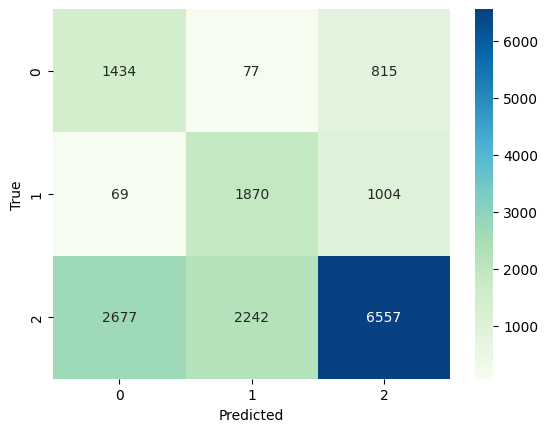

In [24]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_pred_rs, y_test)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Ahora veamos las métricas del árbol.

In [25]:
accuracy=accuracy_score(y_test, y_pred_rs)
recall=recall_score(y_test, y_pred_rs, average='weighted')
f1=f1_score(y_test, y_pred_rs, average='weighted')
precision=precision_score(y_test, y_pred_rs, average='weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.5888922066288445
Recall: 0.5888922066288445
Precision: 0.5986556018249419
f1 score: 0.5716590712534604


In [26]:
print(classification_report(y_test, y_pred_rs))

              precision    recall  f1-score   support

        alto       0.62      0.34      0.44      4180
        bajo       0.64      0.45      0.52      4189
       medio       0.57      0.78      0.66      8376

    accuracy                           0.59     16745
   macro avg       0.61      0.52      0.54     16745
weighted avg       0.60      0.59      0.57     16745



Viendo la lista de importancia de features, resulta ser que ni la cantidad de habitaciones ni la cantidad de dormitorios son considerados para tomar las decisiones respecto a las clases, mientras que la latitud es la feature más importante de nuestro dataset.

In [27]:
sorted(list(zip(df_x.columns.to_list(), arbol_optimizado_rs.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.48818707253072663),
 ('longitud', 0.17503610458610278),
 ('neighbourhood_Puerto Madero', 0.13345620937299477),
 ('neighbourhood_Caballito', 0.06314515326879594),
 ('property_surface_total', 0.05200096756150177),
 ('property_surface_covered', 0.04758552556796928),
 ('property_type_Departamento', 0.029510050194469523),
 ('neighbourhood_Boca', 0.006503386998672001),
 ('neighbourhood_Villa Urquiza', 0.004575529918767242),
 ('property_rooms', 0.0),
 ('property_bedrooms', 0.0),
 ('property_type_PH', 0.0),
 ('neighbourhood_Agronomía', 0.0),
 ('neighbourhood_Almagro', 0.0),
 ('neighbourhood_Balvanera', 0.0),
 ('neighbourhood_Barracas', 0.0),
 ('neighbourhood_Barrio Norte', 0.0),
 ('neighbourhood_Belgrano', 0.0),
 ('neighbourhood_Boedo', 0.0),
 ('neighbourhood_Catalinas', 0.0),
 ('neighbourhood_Centro / Microcentro', 0.0),
 ('neighbourhood_Chacarita', 0.0),
 ('neighbourhood_Coghlan', 0.0),
 ('neighbourhood_Colegiales', 0.0),
 ('neighbourhood_Congreso', 0.0),
 ('neighbourhood_Cons

## Entrenamiento escalando superficies

Para el proximo entrenamiento (y a modo de ver si se producen mejores resultados) se procede a escalar las variables que refieren a la superficie.

### Escalado de datos

Voy a trabajar sobre una copia del dataframe anterior.

In [28]:
df_escalado = df.copy()

Escalo mediante escalado estándar las superficies.

In [29]:
std_scaler = StandardScaler()

std_scaler.fit(pd.DataFrame(df_escalado['property_surface_total']).to_numpy())

df_escalado['property_surface_total'] = std_scaler.transform(pd.DataFrame(df_escalado['property_surface_total']).to_numpy())

In [30]:
std_scaler = StandardScaler()

std_scaler.fit(pd.DataFrame(df_escalado['property_surface_covered']).to_numpy())

df_escalado['property_surface_covered'] = std_scaler.transform(pd.DataFrame(df_escalado['property_surface_covered']).to_numpy())

Genero los dataframes de x (features) e y (targets).

In [31]:
df_escalado_x = df_escalado[features]
df_escalado_y = df_escalado[target]

Genero los conjuntos de train y test.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_escalado_x, df_escalado_y, test_size=0.20, stratify=df_escalado[target].values, random_state=semilla)

### Entrenamiento

Pruebo nuevamente random search optimizando f1 score.

In [33]:
#Cantidad de combinaciones
n = 30
folds = 5

#Cantidad de splits para el Cross Validation
params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(2,20)),
                'ccp_alpha':np.linspace(0.001,0.003),
                'max_depth':list(range(1,20))}

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

# Clasificador
arbol_base = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=arbol_base,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=30,
                   param_distributions={'ccp_alpha': array([0.001     , 0.00104082, 0.00108163, 0.00112245, 0.00116327,
       0.00120408, 0.0012449 , 0.00128571, 0.00132653, 0.00136735,
       0.00140816, 0.00144898, 0.0014898 , 0.00153061, 0.00157143,
       0.00161224, 0.00165306, 0.0...
       0.00263265, 0.00267347, 0.00271429, 0.0027551 , 0.00279592,
       0.00283673, 0.00287755, 0.00291837, 0.00295918, 0.003     ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19]},
                   random_state=137,
                   scoring=make_scorer(f1_score, average=micro))

Muestro los mejores hiperparametros y el mejor score.

In [34]:
print("Mejores hiperparámetros: ", str(randomcv.best_params_))
print("Mejor puntaje: ", str(randomcv.best_score_))

Mejores hiperparámetros:  {'min_samples_split': 14, 'min_samples_leaf': 7, 'max_depth': 11, 'criterion': 'entropy', 'ccp_alpha': 0.0010408163265306122}
Mejor puntaje:  0.5983248296277374


Entreno el árbol con los mejores hiperparametros.

In [35]:
arbol_escalado = DecisionTreeClassifier().set_params(**randomcv.best_params_)

arbol_escalado.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0010408163265306122, criterion='entropy',
                       max_depth=11, min_samples_leaf=7, min_samples_split=14)

Predigo los datos de test.

In [36]:
y_pred_escalado = arbol_escalado.predict(X_test)

Visualizo la matriz de confusiones

Text(50.722222222222214, 0.5, 'True')

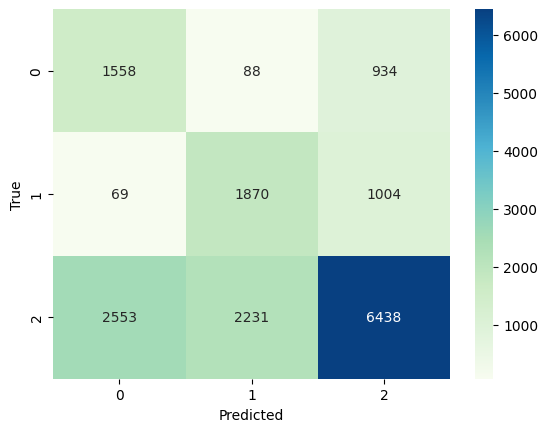

In [37]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_pred_escalado, y_test)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Performance en training

In [38]:
scores = cross_val_score(arbol_escalado, X_train, y_train, cv=kfoldcv)

print("Scores de random search por cada fold: ", scores)

Scores de random search por cada fold:  [0.59883547 0.59570021 0.59671519 0.59626726 0.60410601]


Viendo ahora la performance sobre el conjunto de test

In [39]:
accuracy=accuracy_score(y_test, y_pred_escalado)
recall=recall_score(y_test, y_pred_escalado, average='weighted')
f1=f1_score(y_test, y_pred_escalado, average='weighted')
precision=precision_score(y_test, y_pred_escalado, average='weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.5891908032248432
Recall: 0.5891908032248432
Precision: 0.5966666382859791
f1 score: 0.5748902658724793


## Entrenamiento escalando latitud y longitud

Para el proximo entrenamiento (y a modo de ver si se producen mejores resultados) se procede a escalar las variables que refieren a la superficie.

### Escalado de datos

Voy a trabajar sobre una copia del dataframe anterior.

In [40]:
df_escalado = df.copy()

Escalo mediante escalado estándar las superficies.

In [41]:
std_scaler = StandardScaler()

std_scaler.fit(pd.DataFrame(df_escalado['property_surface_total']).to_numpy())

df_escalado['latitud'] = std_scaler.transform(pd.DataFrame(df_escalado['latitud']).to_numpy())

In [42]:
std_scaler = StandardScaler()

std_scaler.fit(pd.DataFrame(df_escalado['longitud']).to_numpy())

df_escalado['longitud'] = std_scaler.transform(pd.DataFrame(df_escalado['longitud']).to_numpy())

Genero los dataframes de x (features) e y (targets).

In [43]:
df_escalado_x = df_escalado[features]
df_escalado_y = df_escalado[target]

Genero los conjuntos de train y test.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_escalado_x, df_escalado_y, test_size=0.20, stratify=df_escalado[target].values, random_state=semilla)

### Entrenamiento

Pruebo nuevamente random search optimizando f1 score.

In [45]:
#Cantidad de combinaciones
n = 30
folds = 5

#Cantidad de splits para el Cross Validation
params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(2,20)),
                'ccp_alpha':np.linspace(0.001,0.003),
                'max_depth':list(range(1,20))}

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

# Clasificador
arbol_base = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=arbol_base,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=30,
                   param_distributions={'ccp_alpha': array([0.001     , 0.00104082, 0.00108163, 0.00112245, 0.00116327,
       0.00120408, 0.0012449 , 0.00128571, 0.00132653, 0.00136735,
       0.00140816, 0.00144898, 0.0014898 , 0.00153061, 0.00157143,
       0.00161224, 0.00165306, 0.0...
       0.00263265, 0.00267347, 0.00271429, 0.0027551 , 0.00279592,
       0.00283673, 0.00287755, 0.00291837, 0.00295918, 0.003     ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19]},
                   random_state=137,
                   scoring=make_scorer(f1_score, average=micro))

Muestro los mejores hiperparametros y el mejor score.

In [46]:
print("Mejores hiperparámetros: ", str(randomcv.best_params_))
print("Mejor puntaje: ", str(randomcv.best_score_))

Mejores hiperparámetros:  {'min_samples_split': 14, 'min_samples_leaf': 7, 'max_depth': 11, 'criterion': 'entropy', 'ccp_alpha': 0.0010408163265306122}
Mejor puntaje:  0.5977724170084812


Entreno el árbol con los mejores hiperparametros.

In [47]:
arbol_escalado = DecisionTreeClassifier().set_params(**randomcv.best_params_)

arbol_escalado.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0010408163265306122, criterion='entropy',
                       max_depth=11, min_samples_leaf=7, min_samples_split=14)

Predigo los datos de test.

In [48]:
y_pred_escalado = arbol_escalado.predict(X_test)

Visualizo la matriz de confusiones

Text(50.722222222222214, 0.5, 'True')

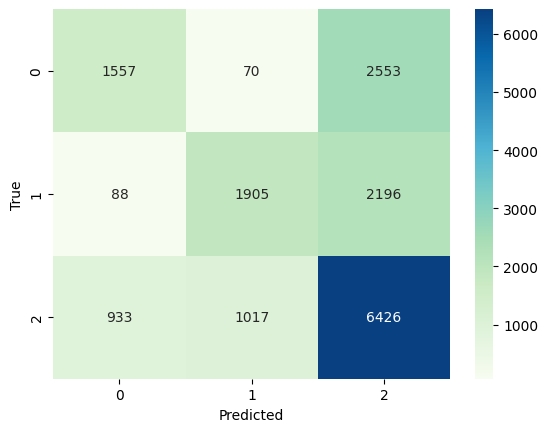

In [49]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_test, y_pred_escalado)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Performance en training

In [50]:
scores = cross_val_score(arbol_escalado, X_train, y_train, cv=kfoldcv)

print("Scores de random search por cada fold: ", scores)

Scores de random search por cada fold:  [0.59898477 0.59338609 0.59671519 0.59589399 0.60388205]


Viendo ahora la performance sobre el conjunto de test

In [51]:
accuracy=accuracy_score(y_test, y_pred_escalado)
recall=recall_score(y_test, y_pred_escalado, average='weighted')
f1=f1_score(y_test, y_pred_escalado, average='weighted')
precision=precision_score(y_test, y_pred_escalado, average='weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.5905046282472379
Recall: 0.5905046282472379
Precision: 0.597679714258561
f1 score: 0.5765698835589803


## Entrenamiento considerando algunos parámetros fijos

Voy a tomar nuevamente los conjuntos sin escalar, ya que parece que el escalado sobre las variables no tiene tanto impacto sobre la performance del árbol.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, stratify=df[target].values, random_state=semilla)

Ya que los parámetros por defecto resultaron en un árbol de decisión con una performance aceptable y mejor que el resto, pruebo optimizar algunos hiperpárametros y dejando fuera otros. Fijo el criterio a `entropy`, ya que es el criterio que tienen en comun todos los randomsearch hasta ahora y el parámetro de poda en `0.0013`, ya que resulto ser uno de los mejores y constantes en los modelos.

In [53]:
#Cantidad de combinaciones
n = 30
folds = 5

#Cantidad de splits para el Cross Validation
params_grid = {'criterion': ['entropy'],
                'min_samples_leaf': list(range(1,10)),
                'min_samples_split': list(range(2,20)),
                'ccp_alpha': [0.0013],
                'max_depth': list(range(1,20))}

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

# Clasificador
arbol_base = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=arbol_base,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=30,
                   param_distributions={'ccp_alpha': [0.0013],
                                        'criterion': ['entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19]},
                   random_state=137,
                   scoring=make_scorer(f1_score, average=micro))

Muestro los hiperparametros encontrados y el mejor puntaje.

In [54]:
print("Mejores hiperparámetros: ", str(randomcv.best_params_))
print("Mejor puntaje: ", str(randomcv.best_score_))

Mejores hiperparámetros:  {'min_samples_split': 12, 'min_samples_leaf': 2, 'max_depth': 18, 'criterion': 'entropy', 'ccp_alpha': 0.0013}
Mejor puntaje:  0.5963241655596078


Genero el nuevo arbol.

In [55]:
arbol_nuevo = DecisionTreeClassifier().set_params(**randomcv.best_params_)

arbol_nuevo.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0013, criterion='entropy', max_depth=18,
                       min_samples_leaf=2, min_samples_split=12)

Predigo de nuevo los valores de testing.

In [56]:
y_pred_nuevo = arbol_nuevo.predict(X_test)

Visualizamos la matriz de confusiones.

Text(50.722222222222214, 0.5, 'True')

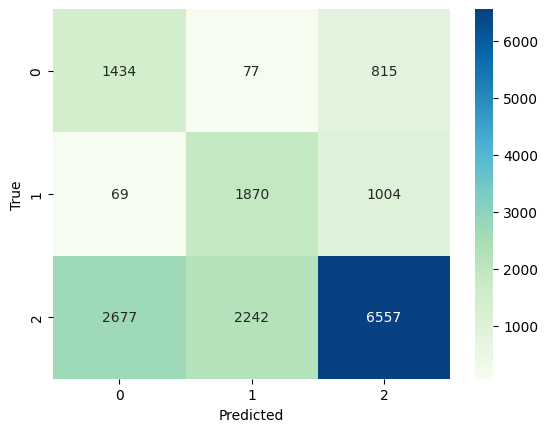

In [57]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_pred_nuevo, y_test)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Veo las métricas del árbol.

In [58]:
scores = cross_val_score(arbol_escalado, X_train, y_train, cv=kfoldcv)

print("Scores de random search por cada fold: ", scores)

Scores de random search por cada fold:  [0.59883547 0.59570021 0.59671519 0.59626726 0.60410601]


In [59]:
accuracy=accuracy_score(y_test, y_pred_nuevo)
recall=recall_score(y_test, y_pred_nuevo, average='weighted')
f1=f1_score(y_test, y_pred_nuevo, average='weighted')
precision=precision_score(y_test, y_pred_nuevo, average='weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.5888922066288445
Recall: 0.5888922066288445
Precision: 0.5986556018249419
f1 score: 0.5716590712534604


Veo las reglas del árbol.

In [60]:
reglas = export_text(arbol_nuevo, feature_names=list(features))
print(reglas)

|--- latitud <= -34.60
|   |--- neighbourhood_Puerto Madero <= 0.50
|   |   |--- longitud <= -34.59
|   |   |   |--- neighbourhood_Caballito <= 0.50
|   |   |   |   |--- property_type_Departamento <= 0.50
|   |   |   |   |   |--- property_surface_total <= 100.50
|   |   |   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |--- latitud >  -34.62
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |--- property_surface_total >  100.50
|   |   |   |   |   |   |--- latitud <= -34.64
|   |   |   |   |   |   |   |--- class: bajo
|   |   |   |   |   |   |--- latitud >  -34.64
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |--- property_type_Departamento >  0.50
|   |   |   |   |   |--- latitud <= -34.60
|   |   |   |   |   |   |--- longitud <= -58.42
|   |   |   |   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |   |   |   |--- latitud <= -34.66
|   |   |   |   |   |   |   |   |   |--- class: bajo
| 

Veo las importancias de los features

In [61]:
sorted(list(zip(df_x.columns.to_list(), arbol_nuevo.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.48818707253072663),
 ('longitud', 0.17503610458610278),
 ('neighbourhood_Puerto Madero', 0.13345620937299477),
 ('neighbourhood_Caballito', 0.06314515326879594),
 ('property_surface_total', 0.05200096756150177),
 ('property_surface_covered', 0.04758552556796928),
 ('property_type_Departamento', 0.029510050194469523),
 ('neighbourhood_Boca', 0.006503386998672001),
 ('neighbourhood_Villa Urquiza', 0.004575529918767242),
 ('property_rooms', 0.0),
 ('property_bedrooms', 0.0),
 ('property_type_PH', 0.0),
 ('neighbourhood_Agronomía', 0.0),
 ('neighbourhood_Almagro', 0.0),
 ('neighbourhood_Balvanera', 0.0),
 ('neighbourhood_Barracas', 0.0),
 ('neighbourhood_Barrio Norte', 0.0),
 ('neighbourhood_Belgrano', 0.0),
 ('neighbourhood_Boedo', 0.0),
 ('neighbourhood_Catalinas', 0.0),
 ('neighbourhood_Centro / Microcentro', 0.0),
 ('neighbourhood_Chacarita', 0.0),
 ('neighbourhood_Coghlan', 0.0),
 ('neighbourhood_Colegiales', 0.0),
 ('neighbourhood_Congreso', 0.0),
 ('neighbourhood_Cons

## Entrenamiento con 100 iteraciones

Por último, realizo todo lo anterior pero cambiando a 100 iteraciones.

In [62]:
#Cantidad de combinaciones
n = 100
folds = 5

#Cantidad de splits para el Cross Validation
params_grid = {'criterion': ['entropy', 'gini'],
                'min_samples_leaf': list(range(1,10)),
                'min_samples_split': list(range(2,20)),
                'ccp_alpha': np.linspace(0.001, 0.003),
                'max_depth': list(range(1,20))}

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

# Clasificador
arbol_base = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score, average='micro')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=arbol_base,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=semilla)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'ccp_alpha': array([0.001     , 0.00104082, 0.00108163, 0.00112245, 0.00116327,
       0.00120408, 0.0012449 , 0.00128571, 0.00132653, 0.00136735,
       0.00140816, 0.00144898, 0.0014898 , 0.00153061, 0.00157143,
       0.00161224, 0.00165306, 0....
       0.00263265, 0.00267347, 0.00271429, 0.0027551 , 0.00279592,
       0.00283673, 0.00287755, 0.00291837, 0.00295918, 0.003     ]),
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19]},
                   random_state=137,
                   scoring=make_scorer(f1_score, average=micro))

Veamos los mejores hiperparametros y el mejor puntaje en cross validation.

In [63]:
print("Mejores hiperparámetros: ", str(randomcv.best_params_))
print("Mejor puntaje: ", str(randomcv.best_score_))

Mejores hiperparámetros:  {'min_samples_split': 15, 'min_samples_leaf': 7, 'max_depth': 17, 'criterion': 'entropy', 'ccp_alpha': 0.0010408163265306122}
Mejor puntaje:  0.5983248296277374


Entreno el arbol con los mejores hiperparametros y predigo los valores del conjunto de test.

In [64]:
arbol_100iter = DecisionTreeClassifier().set_params(**randomcv.best_params_)

arbol_100iter.fit(X_train, y_train)

y_pred_100iter = arbol_100iter.predict(X_test)

Vemos la matriz de confusiones.

Text(50.722222222222214, 0.5, 'True')

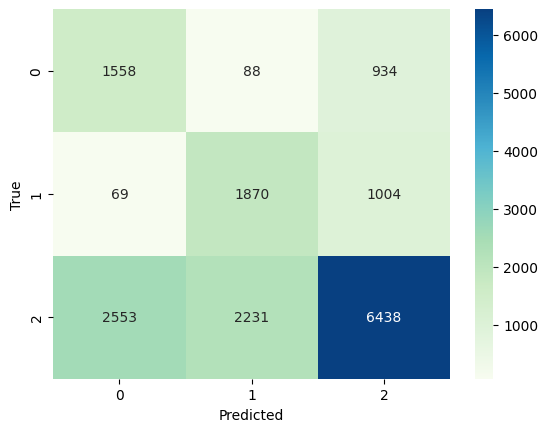

In [65]:
#Creo la matriz de confusión
tabla = confusion_matrix(y_pred_100iter, y_test)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Ahora muestro los scores en training.

In [66]:
scores = cross_val_score(arbol_100iter, X_train, y_train, cv=kfoldcv)

print("Scores de random search por cada fold: ", scores)

Scores de random search por cada fold:  [0.59883547 0.59570021 0.59671519 0.59626726 0.60410601]


Muestro los scores en testing.

In [67]:
accuracy=accuracy_score(y_test, y_pred_100iter)
recall=recall_score(y_test, y_pred_100iter, average='weighted')
f1=f1_score(y_test, y_pred_100iter, average='weighted')
precision=precision_score(y_test, y_pred_100iter, average='weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.5891908032248432
Recall: 0.5891908032248432
Precision: 0.5966666382859791
f1 score: 0.5748902658724793


Muestro las reglas del árbol.

In [68]:
reglas = export_text(arbol_100iter, feature_names=list(features))
print(reglas)

|--- latitud <= -34.60
|   |--- neighbourhood_Puerto Madero <= 0.50
|   |   |--- longitud <= -34.59
|   |   |   |--- neighbourhood_Caballito <= 0.50
|   |   |   |   |--- property_type_Departamento <= 0.50
|   |   |   |   |   |--- property_surface_total <= 100.50
|   |   |   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |--- latitud >  -34.62
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |--- property_surface_total >  100.50
|   |   |   |   |   |   |--- latitud <= -34.64
|   |   |   |   |   |   |   |--- class: bajo
|   |   |   |   |   |   |--- latitud >  -34.64
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |--- property_type_Departamento >  0.50
|   |   |   |   |   |--- latitud <= -34.60
|   |   |   |   |   |   |--- longitud <= -58.42
|   |   |   |   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |   |   |   |--- latitud <= -34.66
|   |   |   |   |   |   |   |   |   |--- class: bajo
| 

Muestro las importancias de los features.

In [69]:
sorted(list(zip(df_x.columns.to_list(), arbol_100iter.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.4849951159419233),
 ('longitud', 0.176192741786207),
 ('neighbourhood_Puerto Madero', 0.13143995905921815),
 ('neighbourhood_Caballito', 0.06219115917822615),
 ('property_surface_total', 0.0546466872821378),
 ('property_surface_covered', 0.04686660562180559),
 ('property_type_Departamento', 0.03275619398365095),
 ('neighbourhood_Boca', 0.006405134125026868),
 ('neighbourhood_Villa Urquiza', 0.004506403021804173),
 ('property_rooms', 0.0),
 ('property_bedrooms', 0.0),
 ('property_type_PH', 0.0),
 ('neighbourhood_Agronomía', 0.0),
 ('neighbourhood_Almagro', 0.0),
 ('neighbourhood_Balvanera', 0.0),
 ('neighbourhood_Barracas', 0.0),
 ('neighbourhood_Barrio Norte', 0.0),
 ('neighbourhood_Belgrano', 0.0),
 ('neighbourhood_Boedo', 0.0),
 ('neighbourhood_Catalinas', 0.0),
 ('neighbourhood_Centro / Microcentro', 0.0),
 ('neighbourhood_Chacarita', 0.0),
 ('neighbourhood_Coghlan', 0.0),
 ('neighbourhood_Colegiales', 0.0),
 ('neighbourhood_Congreso', 0.0),
 ('neighbourhood_Constituc

## Visualización del árbol con mejor performance

Ya que la forma de visualizar las reglas del árbol con mejor performance resulta algo engorrosa, lo visualizo mediante otras librerias que nos den una mejor imágen del mismo. Opto por visualizar 5 niveles del árbol generado en la sección de escalado de superficies, ya que el árbol con los parámetros por defecto podría estar haciendo overfitting al conjunto de datos de entrenamiento.

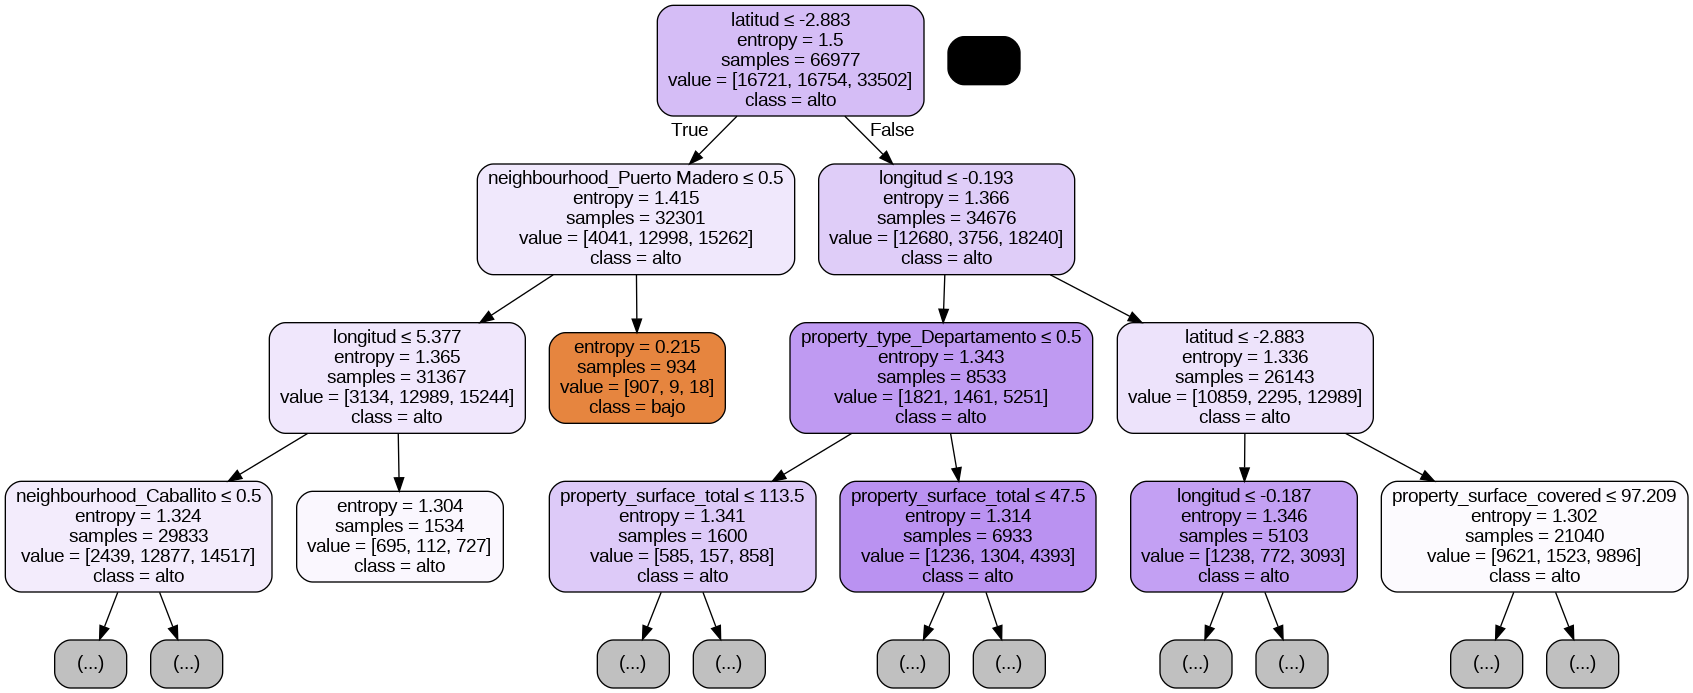

In [70]:
dot_data = StringIO()
export_graphviz(arbol_escalado, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['bajo','medio','alto'],
                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Guardado del modelo

Exporto el modelo obtenido con joblib.

In [71]:
import joblib

joblib.dump(arbol_escalado, "arbol_decision.model")

['arbol_decision.model']

## Conclusiones

De todo el desarrollo y entrenamiento de los árboles se puede concluir que la latitud y la longitud son las features más importantes para predecir el tipo de precio de un aviso de una propiedad, sin embargo los árboles de decisión por si mismos resultaron ser un modelo que no tiene muy buenas métricas para nuestro dataset, siendo el accuracy más elevado del 70%, y un f1 score de 0,70 en testing cuando se utilizan los parámetros por defecto del árbol de decisión. Este es un resultado poco convincente y por ello optamos por no considerar este árbol, e ir por los que hallamos mediante Random Search con superficies escaladas de manera estándar, siendo la mejor accuracy del 59%, con un f1 score de 0,576 (aproximadamente).

Al aumentar las iteraciones a 100 no se mejoraron tanto los parámetros en comparación con la primera optimización hecha con random search.

También notamos que hay 3 features que tienen importancia nula sobre las decisiones, siendo estas `property_rooms`, `property_bedrooms` y `property_type_PH`, así como muchas de las variables aso